In [12]:
# by Joh Schöneberg 2019

%matplotlib inline

import numpy as np
#import pylattice
import matplotlib.pyplot as plt

import pims
import skimage

from mpl_toolkits.mplot3d import Axes3D

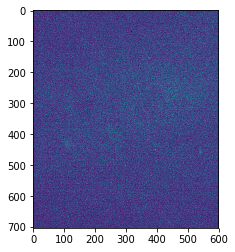

In [2]:
image = skimage.external.tifffile.imread('../test_data/cropped_488_pm50px_maxAmpl_0000.tif')
image = skimage.external.tifffile.imread('/Users/johannesschoeneberg/Dropbox/pylattice_testData/uncropped/S3P5_488_150mw_560_300mw_Objdz150nm_ch1_CAM1_stack0000_560nm_0000000msec_0090116101msecAbs_000x_000y_003z_0000t_decon.tif')

plt.imshow(image[20])

In [3]:
print(image.shape)

(201, 704, 600)


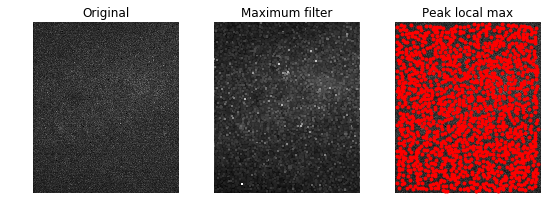

In [24]:
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage import data, img_as_float

windowSize = 8

image_max = ndi.maximum_filter(image[20], size=windowSize, mode='constant')
#image_max

#coordinates=peak_local_max(image[20], num_peaks=2)
coordinates=peak_local_max(image[20],min_distance=windowSize)



# display results
fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(image[20], cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Original')

ax[1].imshow(image_max, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('Maximum filter')

ax[2].imshow(image[20], cmap=plt.cm.gray)
ax[2].autoscale(False)
ax[2].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
ax[2].axis('off')
ax[2].set_title('Peak local max')

fig.tight_layout()

plt.show()

In [25]:
image.shape[2]

600

In [26]:
# make an array of zeros
accumulator = np.zeros(image.shape)

coordinateAccumulator = []


for iz in range(0,image.shape[0]):
    
    coordinates=peak_local_max(image[iz],min_distance=windowSize)
    
    #write the max values into the accumulator at the right positions
    for coord in coordinates:
        coordValue = image[iz][coord[0],coord[1]]
        accumulator[iz,coord[0],coord[1]] = coordValue
        coordinateAccumulator.append([np.array([iz,coord[0],coord[1]]),coordValue])
        

In [27]:
def getAccumulatorCoords(accumulator3d):
    nonzeros = np.nonzero(accumulator3d)
    xs = nonzeros[0]
    ys = nonzeros[1]
    zs = nonzeros[2]
    return(xs,ys,zs)


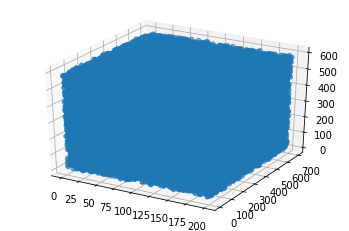

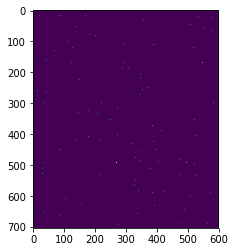

In [114]:


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xs,ys,zs = getAccumulatorCoords(accumulator)
ax.scatter(xs,ys,zs)
plt.show()
plt.imshow(accumulator[16])

In [28]:
#max over all z positions in a z column
# this is how aguet implemented this
accumulator2 = np.zeros(image.shape)


for iz in range(0,image.shape[0]):
    windowSizeHalf = int(windowSize/2)
    from_z = max(0,iz-windowSizeHalf)
    to_z = min(image.shape[2],iz+windowSizeHalf)
    
    from_z = max(0,iz-windowSizeHalf)
    to_z = min(image.shape[2],iz+windowSizeHalf)
    
    from_z = max(0,iz-windowSizeHalf)
    to_z = min(image.shape[2],iz+windowSizeHalf)
    #print(from_z,to_z)
    accumulator2[iz] = np.amax(accumulator[from_z:to_z],axis=0)


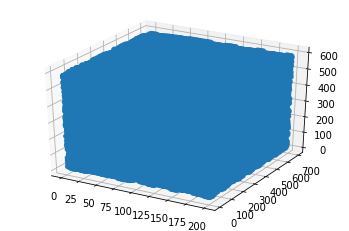

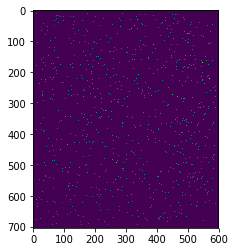

In [116]:
# this is of course now very crowded. That's bad
# maybe that's the reason why the other code spends so much time fitting gaussians...
# it just fits _way_ to many of them?

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xs,ys,zs = getAccumulatorCoords(accumulator2)
ax.scatter(xs,ys,zs)
plt.show()
plt.imshow(accumulator2[10])

In [29]:
# run the peak local max just an other time to get rid of the too many ones
# maybe we can clean it up that way
accumulator3 = np.zeros(image.shape)


for iz in range(0,image.shape[0]):
    
    coordinates=peak_local_max(accumulator2[iz],min_distance=windowSize)
    
    #write the max values into the accumulator at the right positions
    for coord in coordinates:
        coordValue = image[iz][coord[0],coord[1]]
        accumulator3[iz,coord[0],coord[1]] = coordValue
        

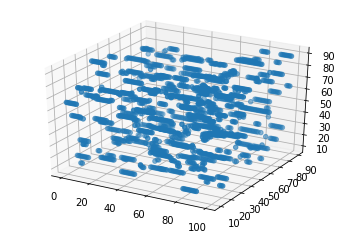

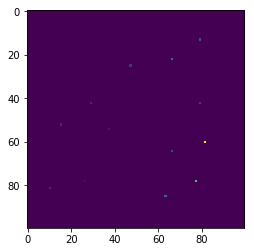

In [14]:
# we cant...
# this is not hte solution to the problem
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xs,ys,zs = getAccumulatorCoords(accumulator3)
ax.scatter(xs,ys,zs)
plt.show()
plt.imshow(accumulator[16])
plt.imshow(accumulator3[15])

In [15]:
# New solution:
# put yourself on every coordinate
# take a cube around yourself -> find the maximum in that cube
# if yourself are the max nothing happens
# if yourself are smaller than the max, elliminate yourself

In [32]:
#max over all z positions in a z column
accumulator_ellimination = accumulator
accumulator_threshold = 8000
n=0

for maxCandidate in coordinateAccumulator:
    maxCandidate_z = maxCandidate[0][0]
    maxCandidate_x = maxCandidate[0][1]
    maxCandidate_y = maxCandidate[0][2]

    maxCandidate_value = maxCandidate[1]
    windowSizeHalf = int(windowSize/2)
    
    from_x = max(0,maxCandidate_x-windowSizeHalf)
    to_x = min(image.shape[0],maxCandidate_x+windowSizeHalf)
    
    from_y = max(0,maxCandidate_y-windowSizeHalf)
    to_y = min(image.shape[1],maxCandidate_y+windowSizeHalf)
    
    from_z = max(0,maxCandidate_z-windowSizeHalf)
    to_z = min(image.shape[2],maxCandidate_z+windowSizeHalf)
    
    try:
        if(maxCandidate_value < accumulator_threshold):
            accumulator_ellimination[maxCandidate_z,maxCandidate_x,maxCandidate_y] = 0
            n=n+1
        if(maxCandidate_value < np.amax(accumulator_ellimination[from_z:to_z,from_x:to_x,from_y:to_y])):
                #print("test")
            accumulator_ellimination[maxCandidate_z,maxCandidate_x,maxCandidate_y] = 0    
            n=n+1
        
    except ValueError:  #raised if `y` is empty.
        pass



In [33]:
print(n)
print("number of maxima")
print(len(np.transpose(np.nonzero(accumulator))))

233712
number of maxima
10196


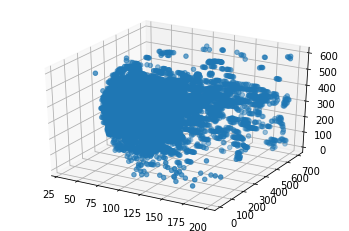

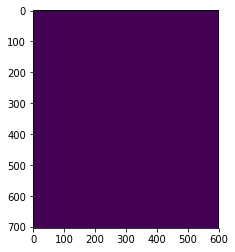

In [34]:
# this looks much much better!!!
# great!
# Now, last step: see if this all makes sense geometrically, i.e. if the axes are correct.
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xs,ys,zs = getAccumulatorCoords(accumulator_ellimination)
ax.scatter(xs,ys,zs)
plt.show()
plt.imshow(accumulator_ellimination[16])

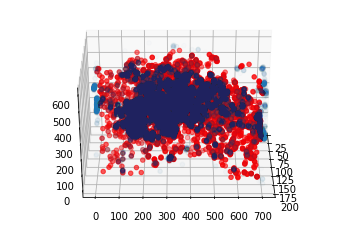

In [17]:
test = image >8000
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xs,ys,zs = getAccumulatorCoords(test)
ax.scatter(xs,ys,zs,alpha = 0.01)
# plot the max coordinates
xs,ys,zs = getAccumulatorCoords(accumulator_ellimination)
ax.scatter(xs,ys,zs,c='red')
ax.view_init(30, 0)

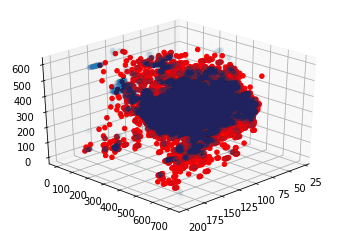

In [18]:
test = image >8000
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xs,ys,zs = getAccumulatorCoords(test)
ax.scatter(xs,ys,zs,alpha = 0.01)
# plot the max coordinates
xs,ys,zs = getAccumulatorCoords(accumulator_ellimination)
ax.scatter(xs,ys,zs,c='red',alpha=1)
ax.view_init(30, 45)

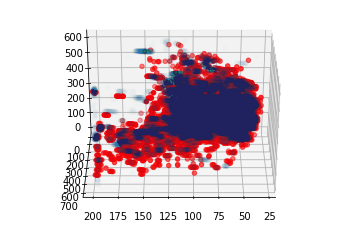

In [19]:
test = image >8000
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xs,ys,zs = getAccumulatorCoords(test)
ax.scatter(xs,ys,zs,alpha = 0.01)
# plot the max coordinates
xs,ys,zs = getAccumulatorCoords(accumulator_ellimination)
ax.scatter(xs,ys,zs,c='red')
ax.view_init(30, 90)

In [20]:
# great this looks all good!
# now package it all into a function

def peak_local_max_3d(image3d,min_distance,threshold=0):
    
    ######### setup
    # make an array of zeros
    accumulator = np.zeros(image.shape)
    
    # accumulator for the coordinates and the coordinate intensities
    coordinateAccumulator = []
    
    ######### 2D
    # find all maxima in every 2D slice of the image
    for iz in range(0,image.shape[0]):
        
        coordinates=peak_local_max(image[iz],min_distance=min_distance)
        
        #write the max values into the accumulator at the right positions
        for coord in coordinates:
            coordValue = image[iz][coord[0],coord[1]]
            accumulator[iz,coord[0],coord[1]] = coordValue
            coordinateAccumulator.append([np.array([iz,coord[0],coord[1]]),coordValue])
            
            

            
    ######### 3D
    # Elliminate all that are too close together
    

    for maxCandidate in coordinateAccumulator:
        maxCandidate_z = maxCandidate[0][0]
        maxCandidate_x = maxCandidate[0][1]
        maxCandidate_y = maxCandidate[0][2]
    
        maxCandidate_value = maxCandidate[1]
        windowSizeHalf = int(windowSize/2)
        #print(windowSizeHalf)
        
#        print(maxCandidate_x-windowSizeHalf)
#        prnt(windowSizeHalf)
        from_x = max(0,maxCandidate_x-windowSizeHalf)
        to_x = min(image.shape[0],maxCandidate_x+windowSizeHalf)
        
        from_y = max(0,maxCandidate_y-windowSizeHalf)
        to_y = min(image.shape[1],maxCandidate_y+windowSizeHalf)
        
        from_z = max(0,maxCandidate_z-windowSizeHalf)
        to_z = min(image.shape[2],maxCandidate_z+windowSizeHalf)
        
        try:
            if(maxCandidate_value < threshold):
                accumulator[maxCandidate_z,maxCandidate_x,maxCandidate_y] = 0
            
            if(maxCandidate_value < np.amax(accumulator[from_z:to_z,from_x:to_x,from_y:to_y])):
                #print("test")
                accumulator[maxCandidate_z,maxCandidate_x,maxCandidate_y] = 0
        except ValueError:  #raised if `y` is empty.
            pass    
    ########## output
    #
    result = np.transpose(np.nonzero(accumulator))
    return(result)

In [21]:
# test the function
maxima = peak_local_max_3d(image,min_distance=8,threshold=8000)
#print(maxima)
print(len(maxima))

10120


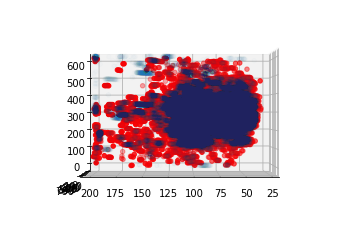

In [22]:
test = image >8000
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xs,ys,zs = getAccumulatorCoords(test)
ax.scatter(xs,ys,zs,alpha = 0.01)
# plot the max coordinates
ax.scatter(maxima[:,0],maxima[:,1],maxima[:,2],c='red')
ax.view_init(0, 90)

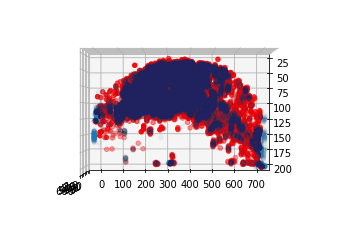

In [23]:
test = image >8000
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xs,ys,zs = getAccumulatorCoords(test)
ax.scatter(xs,ys,zs,alpha = 0.01)
# plot the max coordinates
ax.scatter(maxima[:,0],maxima[:,1],maxima[:,2],c='red')
ax.view_init(90, 0)